# uDOP experiments

> Experimenting uDOP for instrument cross-calibration

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from nbdev.showdoc import *
from nbdev.cli import *

In [ ]:
from pathlib import Path
from fastai.vision.all import *
from fastai.data.all import *
from fastcore.transform import Pipeline
from tqdm import tqdm

from numpy.linalg import svd
from numpy import dot, diag
from pycaltransfer.caltransfer import udop
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import kennard_stone as ks

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import savgol_filter

from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, Analytes, Spectra,
                                    DerivTfm, AnalytesTfm, SNVTfm, RandWAvgTfm, AvgTfm, TrimTfm,
                                    NormalizeTfm, LogTfm)

import warnings
warnings.filterwarnings('ignore')

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
# file getters
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

# Plot utils
def plot_spectra(X, X_names, sample=50, alpha=0.8, color='#333', figsize=(20, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    idx = np.random.randint(X.shape[0], size=sample)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.locator_params(axis="x", nbins=20)
    plt.xlabel('Wavenumber')
    plt.ylabel('Absorbance')
    _ = ax.plot(X_names, X[idx, :].T, lw=1, c=color, alpha=alpha)

## Toy example

In [ ]:
Xs = np.array([
    [1, 0.8],
    [0.82, 0.78],
    [0.75, 0.7]])
Xs -= Xs.mean(axis=0)

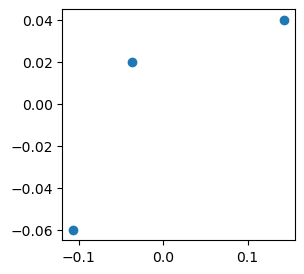

In [ ]:
plt.figure(figsize=(3,3))
plt.scatter(Xs[:,0], Xs[:, 1]);

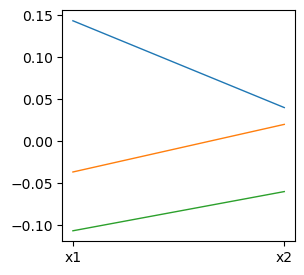

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(['x1', 'x2'], Xs.T, lw=1);

In [ ]:
U, Σ, V_t = svd(Xs)

In [ ]:
U

array([[-0.76788153,  0.27753309,  0.57735027],
       [ 0.14359006, -0.80377146,  0.57735027],
       [ 0.62429148,  0.52623837,  0.57735027]])

In [ ]:
diag(Σ)

array([[0.19328416, 0.        ],
       [0.        , 0.03883171]])

In [ ]:
V_t

array([[-0.94120016, -0.33784946],
       [ 0.33784946, -0.94120016]])

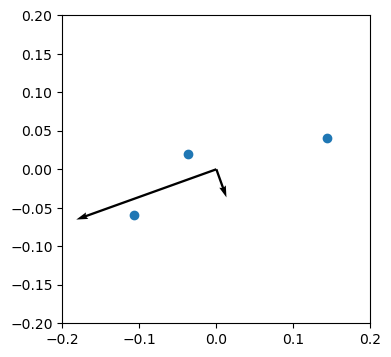

In [ ]:
# Singular vectors
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(Xs[:,0], Xs[:, 1])
ax.quiver([0, 0], [0, 0], 
          np.diag(Σ).dot(V_t)[:,0], np.diag(Σ).dot(V_t)[:,1], 
          angles='xy', scale_units='xy', scale=1)
ax.set_xlim([-0.2, 0.2])
ax.set_ylim([-0.2, 0.2])
ax.set_aspect('equal')

## Data loading

In [ ]:
# KSSL
path = Path('../../_data/kssl-mirs-v2')
paths_kssl = path.ls(); paths_kssl

# keep only when spectra in folder
paths_kssl = [p for p in tqdm(paths_kssl) if len(p.ls()) > 1]; print(f'n samples: {len(paths_kssl)}')

100%|███████████████████████████████████████████████████████| 46305/46305 [00:01<00:00, 27150.33it/s]

n samples: 46251


In [ ]:
tfms = Pipeline([SpectraTfm, AvgTfm, SNVTfm])
X_kssl = np.concatenate([tfms(get_spectra(p)).numpy() for p in paths_kssl])

In [ ]:
X_kssl.shape

(46251, 1700)

In [ ]:
n_kssl_subset = 5000
idx_kssl = np.random.randint(len(X_kssl), size=n_kssl_subset); idx_kssl
Xt = X_kssl[idx_kssl, :]
#Xt = X_kssl

In [ ]:
Ut, Δt, Vt_t = svd(X_kssl[idx_kssl, :])

In [ ]:
print('ut shape:', Ut.shape)
print('dt shape:', Δt.shape)
print('vt_t shape:', Vt_t.shape)

ut shape: (5000, 5000)
dt shape: (1700,)
vt_t shape: (1700, 1700)


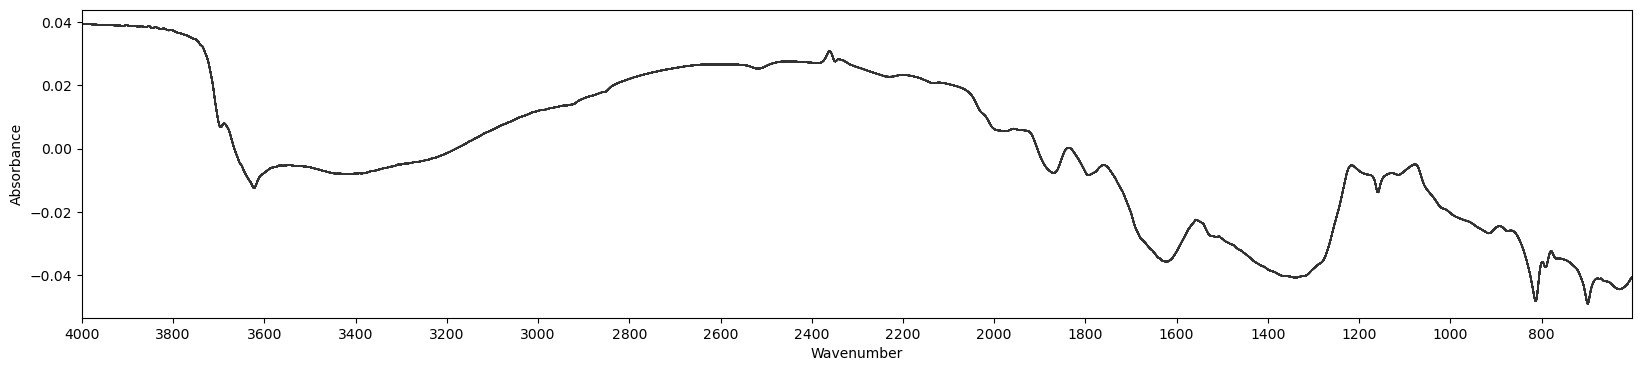

In [ ]:
wns = np.arange(4000, 600, -2)
plot_spectra(Vt_t[0,:].reshape(1, -1), wns)

In [ ]:
pca_kssl = PCA(n_components=20)
Xt_pca = pca_kssl.fit_transform(Xt)
cumsum = np.cumsum(pca_kssl.explained_variance_ratio_); cumsum

array([0.47160345, 0.6177184 , 0.7410451 , 0.84232736, 0.88549376,
       0.9059795 , 0.92569524, 0.9438751 , 0.95529157, 0.9634368 ,
       0.9690098 , 0.9739448 , 0.97739136, 0.98052883, 0.9832557 ,
       0.9852399 , 0.9868423 , 0.9883312 , 0.98957   , 0.99076   ],
      dtype=float32)

In [ ]:
#plt.scatter(X_kssl_pca[:,0], X_kssl_pca[:,1], s=1, alpha=0.1);

In [ ]:
# IAEA-Fukushima andisols
path = Path('../../_data/seibersdorf-mirs')
paths = path.ls(); paths

(#176) [Path('../../_data/seibersdorf-mirs/135'),Path('../../_data/seibersdorf-mirs/95'),Path('../../_data/seibersdorf-mirs/66'),Path('../../_data/seibersdorf-mirs/104'),Path('../../_data/seibersdorf-mirs/68'),Path('../../_data/seibersdorf-mirs/103'),Path('../../_data/seibersdorf-mirs/168'),Path('../../_data/seibersdorf-mirs/157'),Path('../../_data/seibersdorf-mirs/150'),Path('../../_data/seibersdorf-mirs/159')...]

In [ ]:
tfms = Pipeline([SpectraTfm, AvgTfm, TrimTfm, SNVTfm])
Xs = np.concatenate([tfms(get_spectra(p)).numpy() for p in paths])
Xs.shape

(176, 1700)

In [ ]:
?svd

In [ ]:
Us, Δs, Vs_t = svd(Xs, full_matrices=True)

In [ ]:
print('Us shape:', Us.shape)
print('Δs shape:', Δs.shape)
print('Vs_t shape:', Vs_t.shape)
Vs = Vs_t.T

Us shape: (176, 176)
Δs shape: (176,)
Vs_t shape: (176, 1700)


In [ ]:
# My take
diag(Δs).dot(Vs_t).shape

(176, 1700)

In [ ]:
# ADAPT DIRECTION OF LOADINGS

In [ ]:
# Xt_hat = XtVtVs_t
#          (176,1700)(1700,1700)(1700,1700)
Xt_hat = dot(dot(Xt, Vt), Vs_t); Xt_hat.shape

NameError: name 'Vt' is not defined

In [ ]:
D = Xt_hat - Xt; D.shape

In [ ]:
_, _, Vda_t = svd(D)
print(Vda_t.shape)
Vda = Vda_t.T

In [ ]:
I = np.identity(len(Vda_t))

In [ ]:
E = I - dot(Vda, Vda_t); E.shape

In [ ]:
Xs_cc = dot(Xs, E); Xs_cc.shape

In [ ]:
Xs.shape

In [ ]:
## V. Fonseca implementation

In [ ]:
%time E = udop(Xs, Xt, udop_ncomp=3, svd_ncomp=20)

CPU times: user 1min 33s, sys: 4.1 s, total: 1min 38s
Wall time: 19 s


In [ ]:
Xs_cc = Xs.dot(E)

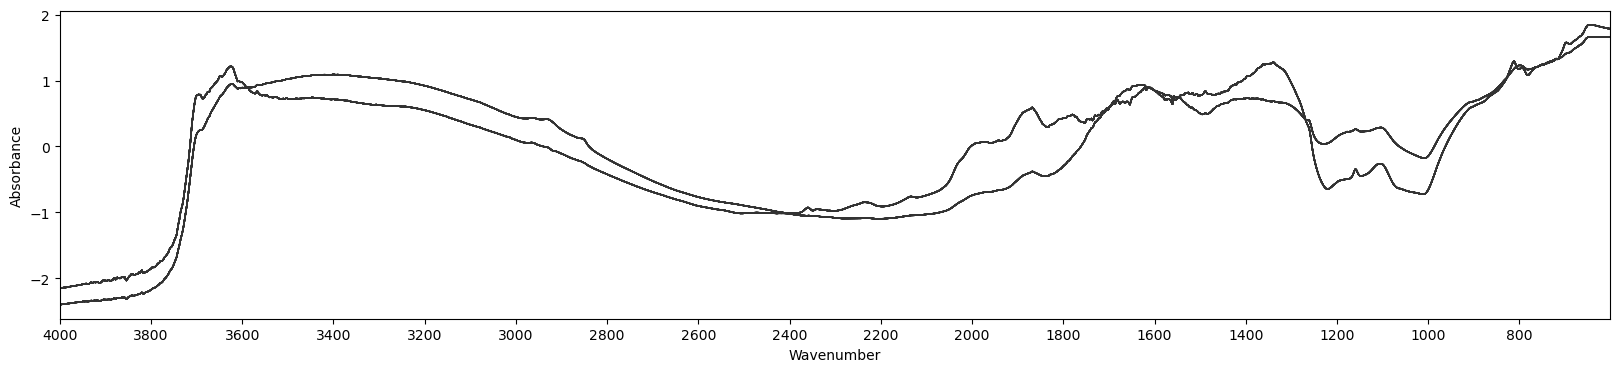

In [ ]:
wns = np.arange(4000, 600, -2)
plot_spectra(np.c_[Xs_cc[0,:], Xs[0,:]].T, wns)
#plot_spectra(Xs[0,:].reshape(1, -1), wns)

In [ ]:
Xs_pca = pca_kssl.transform(Xs)
Xs_cc_pca = pca_kssl.transform(Xs_cc)

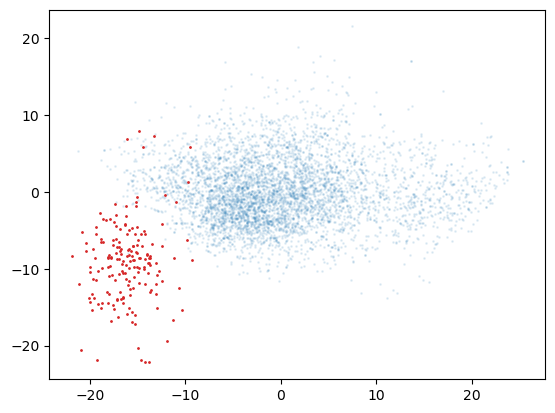

In [ ]:
n1, n2 = 0, 1
plt.scatter(Xt_pca[:,n1], Xt_pca[:, n2], s=1, c='tab:blue', alpha=0.1)
plt.scatter(Xs_pca[:,n1], Xs_pca[:, n2], s=1, c='tab:red', alpha=1);

## Learning

In [ ]:
# Kennard-Stone based splitting
#tfms = Pipeline([SpectraTfm, AvgTfm, TrimTfm])
#X = np.concatenate([tfms(get_spectra(p)).numpy() for p in paths])

#Xs = np.concatenate([AvgTfm()(SpectraTfm()(get_spectra(p))).numpy() for p in paths])
_, _, _, val_idx = ks.train_test_split(Xs_cc, range(len(Xs_cc)), test_size=0.2)

In [ ]:
# kd_cs133', 'ex_cs_total_cs_ratio', 'cs137', 'cs137_total', 'ex_cs137', 'ex_k2o', 'ph', 'c',
# 'n', 'c_n_ratio', 'ex_mgo', 'ex_cao', 'cec'
analyte = 'ex_k2o'

In [ ]:
class cmolKgTfm(Transform):
    def __init__(self, 
                 atomW:float=39.098, # default is K's standard atomic weight
                ): 
        self.atomW = atomW 
        
    def encodes(self, ys:Analytes):
        return ys / self.atomW 

In [ ]:
class cc(Transform):        
    def encodes(self, X:Spectra):
        X = X.detach().numpy()
        return Spectra(torch.Tensor(X.dot(E)))

In [ ]:
def evaluate(model, dls):
    model.eval()
    y_hats = []
    y_trues = []
    for xb, yb in dls:
        y_hats.append(model(xb).detach().numpy())
        y_trues.append(yb.numpy())
    return (np.concatenate(y) for y in (y_hats, y_trues))

In [ ]:
n_smp = None # None for all
dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=[analyte])),
                   get_x=get_spectra,
                   get_y=get_target,
                   #splitter=RandomSplitter(),
                   splitter=IndexSplitter(val_idx),
                   item_tfms=[RandWAvgTfm(), TrimTfm(), SNVTfm(), cc(),
                              cmolKgTfm(), LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=16, drop_last=False)

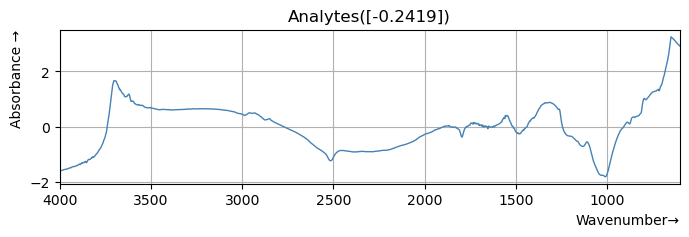

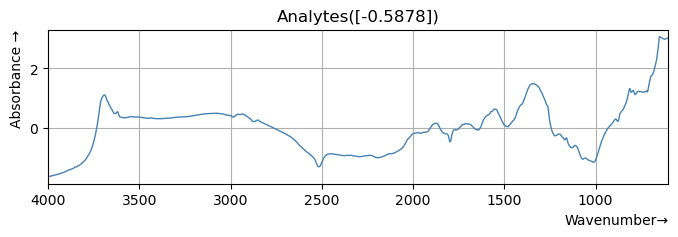

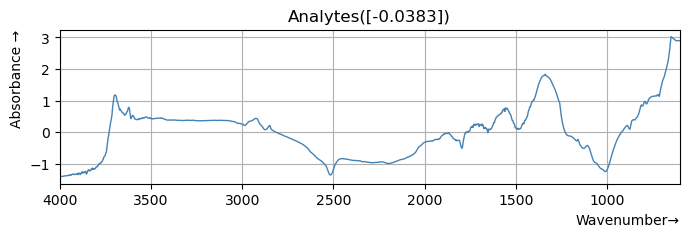

In [ ]:
dls.show_batch(max_n=3)

In [ ]:
# Create model
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)

In [ ]:
# Load KSSL trained model
weights_paths = '../../_data/models/xresnet18-kex-mirs-kssl-20-epochs-lr-1e3-r2-0.813-260323.pth'
xresnet_dict = torch.load(weights_paths, map_location=torch.device('cpu')) 
model.load_state_dict(xresnet_dict['model'])

<All keys matched successfully>

r2:  -2.291608120497246


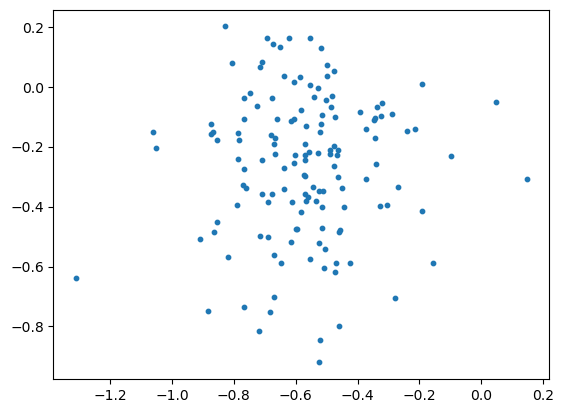

In [ ]:
y_hat, y_true = evaluate(model, dls.train)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=10);

## Finetuning

In [ ]:
# Create learner
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=R2Score()).to_fp16()

In [ ]:
learn.summary()

XResNet (Input shape: 16 x 1 x 1700)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 32 x 850       
Conv1d                                    96         False     
BatchNorm1d                               64         False     
ReLU                                                           
Conv1d                                    3072       False     
BatchNorm1d                               64         False     
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 850       
Conv1d                                    6144       False     
BatchNorm1d                               128        False     
ReLU                                                           
____________________________________________________________________________
                     16 x 64 x 425       
MaxPool1d                                  

In [ ]:
#learn.freeze()

In [ ]:
# 0, 1, 4, 5
#list(learn.model.parameters())[0].shape

torch.Size([32, 1, 3])

In [ ]:
# freeze all
for m in learn.model.parameters():
    m.requires_grad = False

In [ ]:
# Unfreeze last linear
list(learn.model.parameters())[-2].requires_grad = True

In [ ]:
# unfreeze first and last
#for i in [0, 1, 3, 4]:
#    list(learn.model.parameters())[i].requires_grad = True

In [ ]:
#learn.freeze_to(-1)

SuggestedLRs(valley=0.009120108559727669)

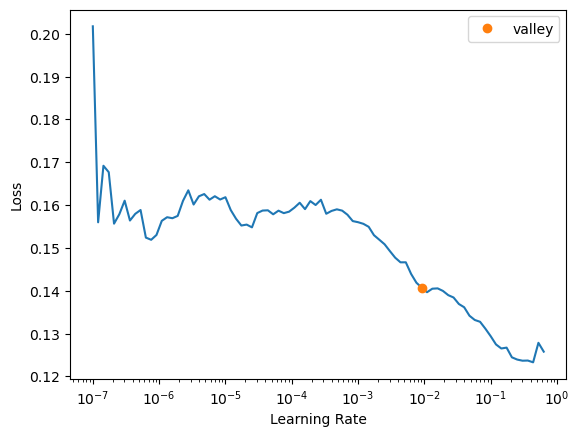

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, 5e-2)

epoch,train_loss,valid_loss,r2_score,time
0,0.020175,0.041259,0.422136,00:07
1,0.020038,0.042735,0.401464,00:07
2,0.020896,0.041389,0.420324,00:06
3,0.021245,0.045296,0.365602,00:06
4,0.021697,0.048171,0.325335,00:06
5,0.021614,0.042645,0.402731,00:06
6,0.020726,0.045907,0.357045,00:06
7,0.020691,0.041170,0.423387,00:06
8,0.020155,0.045485,0.362952,00:06
9,0.020108,0.042807,0.400465,00:06


r2:  0.7008943254860415


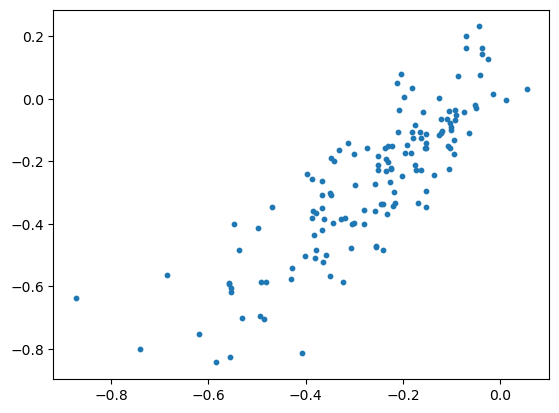

In [ ]:
# Train
y_hat, y_true = evaluate(model, dls.train)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=10);

r2:  0.473220192382916


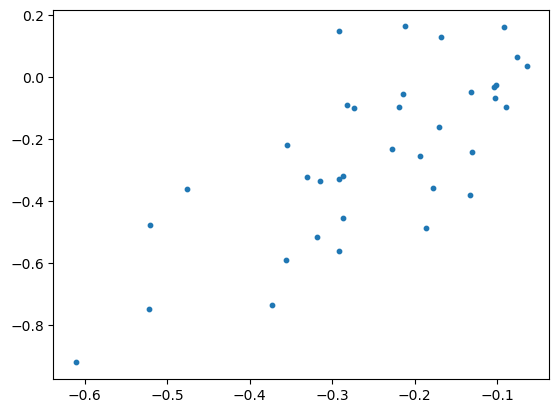

In [ ]:
# Valid
y_hat, y_true = evaluate(model, dls.valid)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=10);

In [ ]:
learn.unfreeze()

SuggestedLRs(valley=0.00013182566908653826)

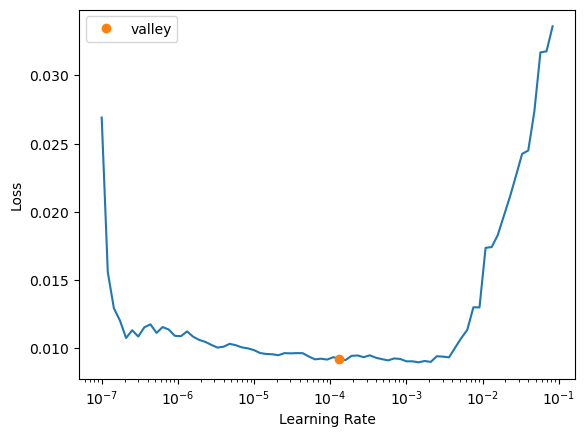

In [ ]:
learn.lr_find()

In [ ]:
#learn.fit_one_cycle(20, lr_max=slice(1e-6,1e-4))
learn.fit_one_cycle(20, lr_max=slice(1e-2,1e-5))

epoch,train_loss,valid_loss,r2_score,time
0,0.087800,0.080614,-0.129041,00:10
1,0.088548,0.086021,-0.204780,00:11
2,0.087857,0.080513,-0.127639,00:10
3,0.088383,0.075421,-0.056322,00:10
4,0.087698,0.074337,-0.041133,00:10
5,0.085608,0.078687,-0.102064,00:10
6,0.084128,0.083835,-0.174159,00:10
7,0.083913,0.074181,-0.038944,00:10
8,0.082868,0.076396,-0.069967,00:11
9,0.081983,0.073154,-0.024564,00:10


KeyboardInterrupt: 

r2:  0.9198457142465807


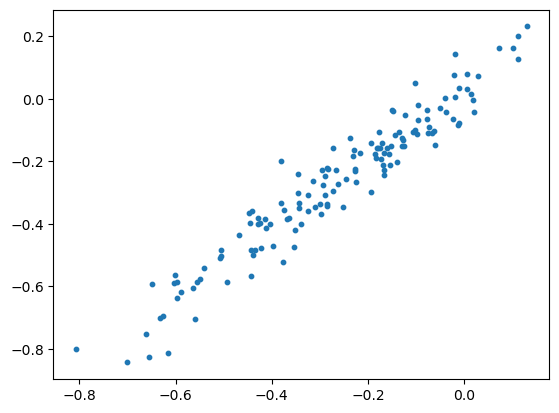

In [ ]:
# Train
y_hat, y_true = evaluate(model, dls.train)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=10);

r2:  0.432419245037878


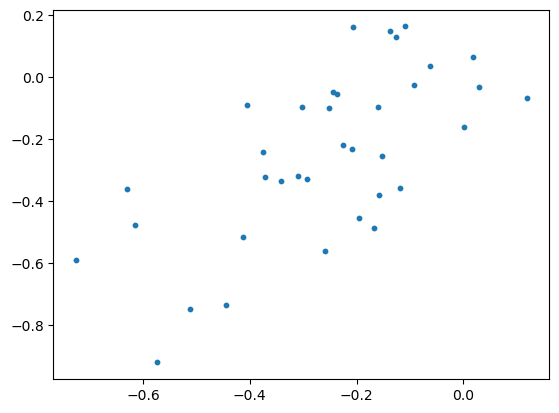

In [ ]:
# Valid
y_hat, y_true = evaluate(model, dls.valid)
print('r2: ', r2_score(y_true, y_hat))
plt.scatter(y_hat, y_true, s=10);